In [65]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2


import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt

import random

from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from scipy.optimize import minimize
from itertools import combinations

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler, BackendSampler, BackendSamplerV2

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import QAOAAnsatz

from qiskit.circuit.library import EfficientSU2


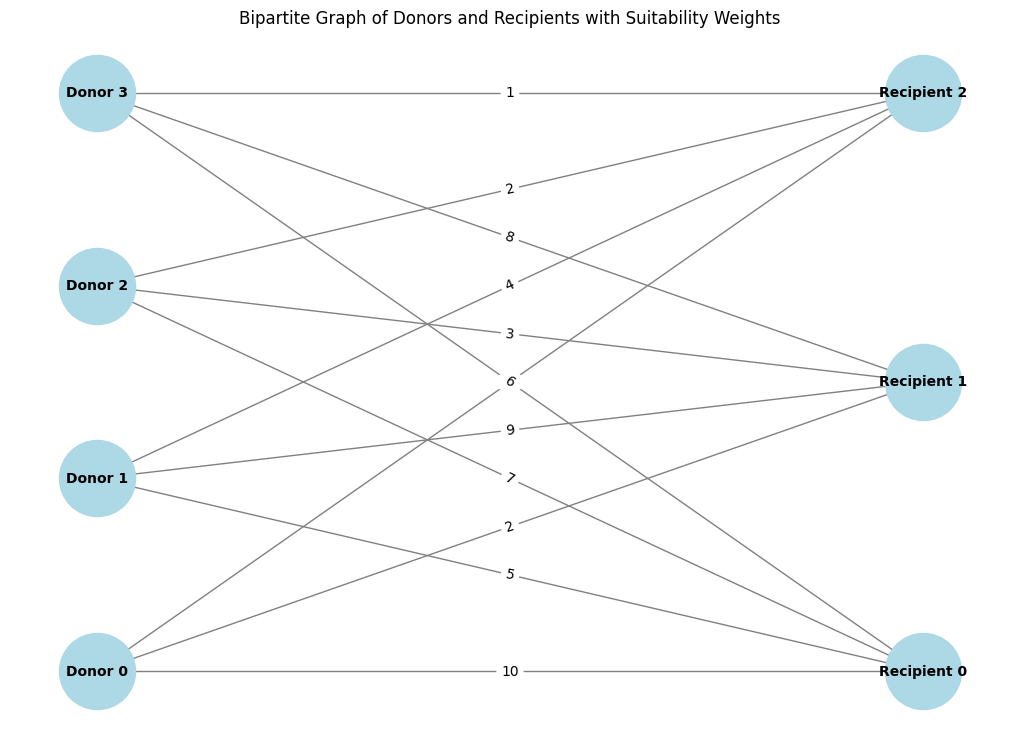

In [66]:
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization import QuadraticProgram

# Define the problem
n_donors = 4  # Number of donors
n_recipients = 3  # Number of recipients
weights = [
    [10, 2, 1],  # Donor 0
    [5, 9, 4],   # Donor 1
    [7, 3, 2],  # Donor 2
    [6, 8, 1]   # Donor 4
]  # Example weights

# Initialize QUBO
qubo = QuadraticProgram()

for i in range(n_donors):
    for j in range(n_recipients):
        qubo.binary_var(name=f"x_{i}_{j}")

objective_terms = []
for i in range(n_donors):
    for j in range(n_recipients):
        objective_terms.append(weights[i][j])

qubo.maximize(linear={f"x_{i}_{j}": weights[i][j] for i in range(n_donors) for j in range(n_recipients)})

G = nx.Graph()

donor_nodes = [f"Donor {i}" for i in range(n_donors)]
recipient_nodes = [f"Recipient {j}" for j in range(n_recipients)]
G.add_nodes_from(donor_nodes, bipartite=0)
G.add_nodes_from(recipient_nodes, bipartite=1)

for i in range(n_donors):
    for j in range(n_recipients):
        G.add_edge(donor_nodes[i], recipient_nodes[j], weight=weights[i][j])

# Draw the bipartite graph
pos = nx.bipartite_layout(G, nodes=donor_nodes)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Bipartite Graph of Donors and Recipients with Suitability Weights")
plt.show()


In [67]:
# Add constraints for donors (each donor must match with one recipient)
for i in range(n_donors):
    qubo.linear_constraint(linear={f"x_{i}_{j}": 1 for j in range(n_recipients)}, sense='<=', rhs=1, name=f"donor_{i}")

# Add constraints for recipients (each recipient must match with one donor)
for j in range(n_recipients):
    qubo.linear_constraint(linear={f"x_{i}_{j}": 1 for i in range(n_donors)}, sense='==', rhs=1, name=f"recipient_{j}")


In [68]:
print(qubo.prettyprint())

Problem name: 

Maximize
  10*x_0_0 + 2*x_0_1 + x_0_2 + 5*x_1_0 + 9*x_1_1 + 4*x_1_2 + 7*x_2_0 + 3*x_2_1
  + 2*x_2_2 + 6*x_3_0 + 8*x_3_1 + x_3_2

Subject to
  Linear constraints (7)
    x_0_0 + x_0_1 + x_0_2 <= 1  'donor_0'
    x_1_0 + x_1_1 + x_1_2 <= 1  'donor_1'
    x_2_0 + x_2_1 + x_2_2 <= 1  'donor_2'
    x_3_0 + x_3_1 + x_3_2 <= 1  'donor_3'
    x_0_0 + x_1_0 + x_2_0 + x_3_0 == 1  'recipient_0'
    x_0_1 + x_1_1 + x_2_1 + x_3_1 == 1  'recipient_1'
    x_0_2 + x_1_2 + x_2_2 + x_3_2 == 1  'recipient_2'

  Binary variables (12)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2 x_3_0 x_3_1 x_3_2



In [73]:
backend = AerSimulator(max_parallel_shots=1)

# Set up the optimizer
optimizer = COBYLA()
sampler = Sampler()

# Set up the QAOA with the Estimator primitive
estimator = Estimator()
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=4) 
qubo_to_qubo = QuadraticProgramToQubo()

qubo_model = qubo_to_qubo.convert(qubo)


ising = qubo_model.to_ising()

print(qubo_model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 1544 x_0_0 - 1536 x_0_1 - 1535 x_0_2 - 1539 x_1_0 - 1543 x_1_1
      - 1538 x_1_2 - 1541 x_2_0 - 1537 x_2_1 - 1536 x_2_2 - 1540 x_3_0
      - 1542 x_3_1 - 1535 x_3_2 + [ 1534 x_0_0^2 + 118 x_0_0*x_0_1
      + 118 x_0_0*x_0_2 + 3068 x_0_0*x_1_0 + 3068 x_0_0*x_2_0 + 3068 x_0_0*x_3_0
      + 1534 x_0_1^2 + 118 x_0_1*x_0_2 + 3068 x_0_1*x_1_1 + 3068 x_0_1*x_2_1
      + 3068 x_0_1*x_3_1 + 1534 x_0_2^2 + 3068 x_0_2*x_1_2 + 3068 x_0_2*x_2_2
      + 3068 x_0_2*x_3_2 + 1534 x_1_0^2 + 118 x_1_0*x_1_1 + 118 x_1_0*x_1_2
      + 3068 x_1_0*x_2_0 + 3068 x_1_0*x_3_0 + 1534 x_1_1^2 + 118 x_1_1*x_1_2
      + 3068 x_1_1*x_2_1 + 3068 x_1_1*x_3_1 + 1534 x_1_2^2 + 3068 x_1_2*x_2_2
      + 3068 x_1_2*x_3_2 + 1534 x_2_0^2 + 118 x_2_0*x_2_1 + 118 x_2_0*x_2_2
      + 3068 x_2_0*x_3_0 + 1534 x_2_1^2 + 118 x_2_1*x_2_2 + 3068 x_2_1*x_3_1
      + 1534 x_2_2^2 + 3068 x_2_2*x_3_2 + 1534 x_3_0^2 + 118 x_3_0*x_3_1
   

C:\Users\asus\AppData\Local\Temp\ipykernel_17988\2385223632.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\asus\AppData\Local\Temp\ipykernel_17988\2385223632.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [75]:
# Use Minimum Eigen Optimizer to solve the QUBO
minimum_eigen_optimizer = MinimumEigenOptimizer(qaoa)
print("Here!")
result = minimum_eigen_optimizer.solve(qubo)

# Extract results
print("Solution:", result)
print("Objective value:", result.fval)
#result = qaoa.compute_minimum_eigenvalue(operator=ising[0])

print(result.x)
# Print matched pairs
for i in range(n_donors):
    for j in range(n_recipients):
        if result.x[i * n_recipients + j] > 0.5: #Bu kısmı değitirmem gerekebilir.
            print(f"Donor {i} matched with Recipient {j}")

#print("Optimal value:", result.eigenvalue)
#print("Optimal solution:", result.eigenstate)

Here!
Solution: fval=22.0, x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_3_0=0.0, x_3_1=1.0, x_3_2=0.0, status=SUCCESS
Objective value: 22.0
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
Donor 0 matched with Recipient 0
Donor 1 matched with Recipient 2
Donor 3 matched with Recipient 1


In [27]:
optimal_solution = result.eigenstate
most_probable_solution = max(optimal_solution, key=optimal_solution.get)
probability = optimal_solution[most_probable_solution]

# Convert the integer to a binary string
binary_string = format(most_probable_solution, '0' + str(n_donors * n_recipients) + 'b')

# Decode the binary string
matches = []
index = 0
for i in range(n_donors):
    for j in range(n_recipients):
        if binary_string[index] == '1':
            matches.append((i, j))
        index += 1

# Print the matches
print(f"Optimal value: {result.eigenvalue}")
print(f"Optimal solution (binary string): {binary_string}")
print(f"Donor-Recipient matches:")
for donor, recipient in matches:
    print(f"Donor {donor} is matched with Recipient {recipient}")

AttributeError: 'MinimumEigenOptimizationResult' object has no attribute 'eigenstate'

In [11]:
print(binary_vector)

NameError: name 'binary_vector' is not defined

In [50]:
initial_state = None
mixer = None

# Create the QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(operator=operator, reps=reps, initial_state=initial_state, mixer_operator=mixer)

# Draw the QAOA circuit
circuit_drawer(qaoa_ansatz.decompose(), output='mpl')

NameError: name 'operator' is not defined